### pytorch LSTM 예제
#### 순환 신경망(Recurrent Neural Network, RNN)
  - 입력과 출력을 시퀀스 단위로 처리하는 시퀀스(Sequence) 모델
  - 언어 모델과 같이 순서가 있는 데이터에 사용하는 딥러닝 구조
  
 <img src= 'https://miro.medium.com/v2/resize:fit:1194/1*B0q2ZLsUUw31eEImeVf3PQ.png' align="center" height=200 widrh=300>

 - 시계열에서는 자기상관관계의 크기를 신경망을 가중치를 통해서 학습함.
 - 선형모형에 대해서 비선형적인 모형의 대표가 되고 있음.


#### Tensorflowr tutorial
  - [텐서플로우 구조화된 데이터 예제](https://www.tensorflow.org/tutorials/structured_data/time_series?hl=ko)

  - 전체적인 모델 연구과정을 잘 보여줌
  - 데이터에 대한 전처리 및 전환
  - 모델의 설계와 훈련 과정
  - 벤치마킹 과정 등을 잘 보여주는 예제
  




### (복습) 주가 데이터 가져오기

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import requests                 #네트워크 접근 라이브러리
from bs4 import BeautifulSoup   #웹사이트 접근하는 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

target = '삼성전자'

# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와
# 네이버 금융(http://finance.naver.com)에 넣어줌

code_krx = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌
code_krx.종목코드 = code_krx.종목코드.map('{:06d}'.format)
# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다.
code_krx = code_krx[['회사명', '종목코드']]
# code_krx
target_code = code_krx[code_krx['회사명']==target]
target_code

,회사명,종목코드
2028,삼성전자,005930


In [ ]:
# 종목코드로 네이버에서 종목 주소 생성 확인
def get_url(code): #(item_name, code_df):
    url = 'https://finance.naver.com/item/sise_day.naver?code='+'{code}'.format(code=code).lstrip()
    return url
code = target_code['종목코드'].iloc[0]
url = get_url(code)
url

'https://finance.naver.com/item/sise_day.naver?code=005930'

In [ ]:
# 위에서 찾은 네이버 타겟종목 페이지에서 마지막 페이지 크기 확인
url_page = url + '&page=1'
headers = {'User-agent':'Mozilla/5.0'}
html = requests.get(url_page, headers=headers).text
soup = BeautifulSoup(html,"html.parser")
tags = soup.find_all('a')
# print(tags[11]["href"])
last_page = tags[11]["href"]
last_page = last_page.split('=')[2]
last_page
# print(f"target_code :회사명 == [{target_code['회사명'].iloc[0]}] 종목코드 == [{target_code['종목코드'].iloc[0]}] 마지막 페이지 == [{last_page}]")

'689'

In [ ]:
last_page = 50 # 임시 50 페이지 까지만

# 일 데이터를 담을 df_code라는 DataFrame 정의
df_code = pd.DataFrame()
url.lstrip()
for page in range(1,int(last_page)+1):
    req = requests.get(f'{url}&page={page}',headers=headers)
    df_code = pd.concat([df_code,pd.read_html(req.text,encoding='euc-kr')[0]],ignore_index=True)

# df.dropna()를 이용해 결측값 있는 행 제거
df_code = df_code.dropna()
df_code.reset_index(drop=True, inplace=True)

# 상위 15개 데이터 확인하기
df_code.head(15)

,날짜,종가,전일비,시가,고가,저가,거래량
0,2023.11.30,72800.0,100.0,72700.0,72800.0,72200.0,15226770.0
1,2023.11.29,72700.0,0.0,72400.0,72800.0,72200.0,9283933.0
2,2023.11.28,72700.0,1400.0,71400.0,72700.0,71300.0,13283081.0
3,2023.11.27,71300.0,400.0,71500.0,72100.0,71100.0,9113857.0
4,2023.11.24,71700.0,700.0,72400.0,72600.0,71700.0,6676685.0
5,2023.11.23,72400.0,400.0,73000.0,73200.0,72200.0,6775614.0
6,2023.11.22,72800.0,0.0,72200.0,73000.0,71900.0,11105143.0
7,2023.11.21,72800.0,100.0,73100.0,73400.0,72700.0,9712881.0
8,2023.11.20,72700.0,200.0,72100.0,73000.0,72100.0,10610157.0
9,2023.11.17,72500.0,300.0,72300.0,73000.0,72300.0,11494644.0


In [ ]:
# 한글로 된 컬럼명을 영어로 바꿔줌
stock_data = df_code.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'})
# 데이터의 타입을 int형으로 바꿔줌
stock_data[['close', 'diff', 'open', 'high', 'low', 'volume']] = stock_data[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(float)
# 컬럼명 'date'의 타입을 date로 바꿔줌
stock_data['date'] = pd.to_datetime(stock_data['date'])
# 일자(date)를 기준으로  정렬
stock_data = stock_data.sort_values(by=['date'],ascending = True)
# 상위 5개 데이터 확인
print(stock_data.shape)
stock_data.reset_index(drop=True, inplace=True)
stock_data.head(15)

(500, 7)


,date,close,diff,open,high,low,volume
0,2021-11-23,75300.0,400.0,76000.0,76000.0,74500.0,22029195.0
1,2021-11-24,74800.0,500.0,76000.0,76200.0,74100.0,15652305.0
2,2021-11-25,73700.0,1100.0,75100.0,75100.0,73600.0,12559258.0
3,2021-11-26,72300.0,1400.0,73500.0,74100.0,72000.0,13002242.0
4,2021-11-29,72300.0,0.0,71700.0,73000.0,71400.0,16682559.0
5,2021-11-30,71300.0,1000.0,73200.0,73900.0,70500.0,30364841.0
6,2021-12-01,74400.0,3100.0,72000.0,74800.0,71600.0,21954856.0
7,2021-12-02,75800.0,1400.0,73900.0,75800.0,73800.0,23652940.0
8,2021-12-03,75600.0,200.0,75600.0,76000.0,74100.0,18330240.0
9,2021-12-06,76300.0,700.0,75100.0,76700.0,74900.0,16391250.0


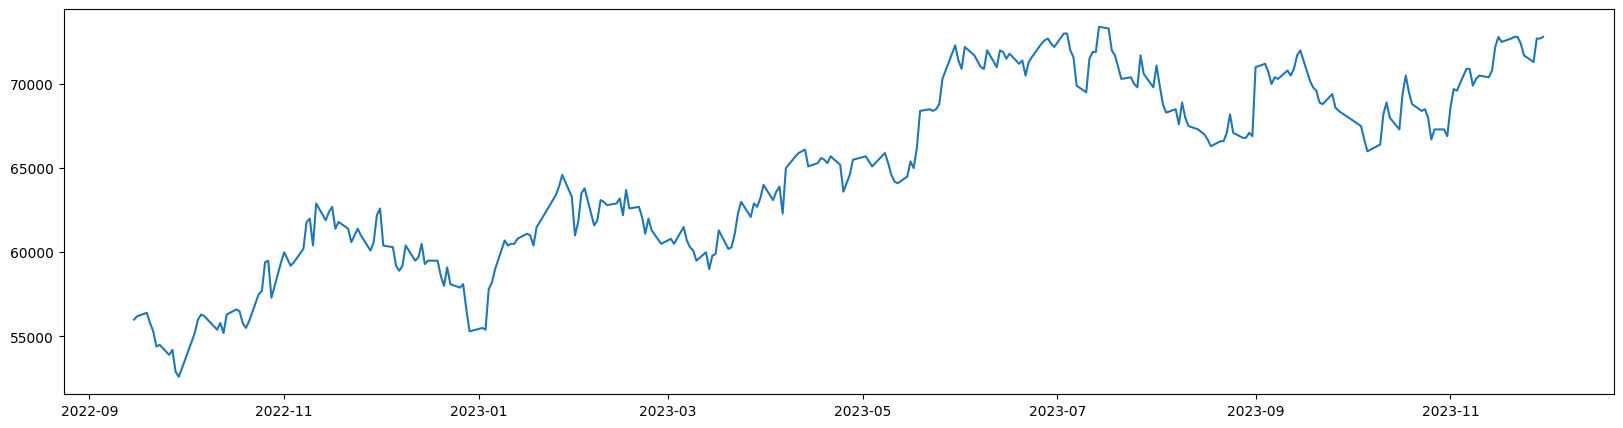

In [ ]:
slice_data = stock_data.iloc[-300:,:] # 특정 기간을 어림으로 분리
slice_data.reset_index(drop=True, inplace=True)
plt.figure(figsize=(20,5))
plt.plot(slice_data['date'],slice_data['close'])
plt.show

slice_data = slice_data.set_index('date')
slice_data.to_csv('stock_data_01.csv')

### 데이터 로드 및 정규화

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
df = pd.read_csv('./stock_data_01.csv')

# 입력으로 7일 데이터로 (window size) 들어가고 batch size는 임의로 지정
seq_length = 5
batch = 10

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
# df = df[::-1] # 데이터 저장 형태에 따라 수정
train_size = int(len(df)*0.95) # 일반적으로는 8:1:1
train_set = df[0:train_size]
test_set = df[train_size-seq_length:]
#본 예제에는 validation 구간이 없슴. 사실 적정한 학습을 위해서는 validataion dataset 구간이 필요함.

In [ ]:
train_set = train_set.set_index('date')
print(f" train_dataset : \n {train_set.head()}")
test_set = test_set.set_index('date')
print(f" \n test_dataset : \n {test_set.head()}")

 train_dataset : 
               close   diff     open     high      low      volume
date                                                             
2022-09-15  56000.0  800.0  57000.0  57100.0  56000.0  11664819.0
2022-09-16  56200.0  200.0  55600.0  56400.0  55500.0  13456503.0
2022-09-19  56400.0  200.0  56300.0  57000.0  56000.0  12278653.0
2022-09-20  55800.0  600.0  56400.0  57000.0  55800.0  14041465.0
2022-09-21  55300.0  500.0  55400.0  55500.0  55000.0  11863700.0
 
 test_dataset : 
               close    diff     open     high      low      volume
date                                                              
2023-11-03  69600.0   100.0  69700.0  70200.0  69500.0  10322234.0
2023-11-06  70900.0  1300.0  69800.0  70900.0  69300.0  22228489.0
2023-11-07  70900.0     0.0  70600.0  70900.0  70000.0  17228731.0
2023-11-08  69900.0  1000.0  71300.0  71400.0  69700.0  12901310.0
2023-11-09  70300.0   400.0  69900.0  70800.0  69600.0  12301373.0


In [ ]:
# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1] = scaler_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, -1] = scaler_y.transform(test_set.iloc[:, [-1]])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

In [ ]:
# GPU
use_gpu = False             # 'use gpu'
gpu = 0                    # 'gpu'
use_multi_gpu = False      # 'use multiple gpus'
devices = '0,1,2,3'        # 'device ids of multile gpus'

# use_gpu = True if torch.cuda.is_available() and use_gpu else False
# if use_gpu and use_multi_gpu:
#     dvices = devices.replace(' ', '')
#     device_ids = devices.split(',')
#     device_ids = [int(id_) for id_ in device_ids]
#     gpu = device_ids[0]

if use_gpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu) if not use_multi_gpu else devices
    device = torch.device('cuda:{}'.format(gpu))
    print('Use GPU: cuda:{}'.format(gpu))
else:
    device = torch.device('cpu')
    print('Use CPU')

device

Use CPU


device(type='cpu')

In [ ]:

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,
                        drop_last=True)

In [ ]:
# 설정값
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
nb_epochs = 100

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [ ]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):

    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs

    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples

            # seq별 hidden state reset
            model.reset_hidden_state()

            # H(x) 계산
            outputs = model(x_train)

            # cost 계산
            loss = criterion(outputs, y_train)

            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):

            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')

                break

    return model.eval(), train_hist

In [ ]:
# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

In [ ]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [ ]:
# 모델 저장
PATH = "./Timeseries_LSTM_data-02-stock_daily_.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

In [ ]:
# 예측 테스트
with torch.no_grad():
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

In [ ]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot")
plt.show()